In [1]:
!pip install livelossplot;
!pip install torchsummary;
!pip install torchvision;

import math;
from inspect import isfunction;
from functools import partial;

%matplotlib inline
import matplotlib.pyplot as plt;
#from einops import rearrange


import torch.nn as nn;
import torch.nn.functional as F;
import torchvision;
import numpy as np;
from torchvision import transforms;
from livelossplot import PlotLosses;
from torchvision import transforms;
from torchvision.utils import make_grid;
from einops import rearrange
from torch import  einsum
from torchsummary import summary;

import pandas as pd;
from itertools import compress;

ModuleNotFoundError: No module named 'einops'

In [ ]:
import math
import random
from inspect import isfunction
from functools import partial

# %matplotlib inline
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# from einops import rearrange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from torchvision import transforms

In [2]:





# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html
class BasicBlock(nn.Module):
        def __init__(self, in_channels, out_channels, downsample):
            super(BasicBlock, self).__init__()
            
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU(inplace=True)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.downsample = downsample
            self.shortcut=nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        def forward(self, x):
            identity = x

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.bn2(out)

            if self.downsample is not None:
                identity = self.shortcut(x)
            else:
                identity=x
            out += identity
            out = self.relu(out)

            return out    
class ResNet18(nn.Module):
    def __init__(self, num_channels=3):
        super(ResNet18, self).__init__()
        
        # define ResNet-18 architecture with 1 output channel
        self.resnet = nn.Sequential(
            nn.Conv2d(num_channels, 8, kernel_size=(3,3), stride=1, padding=0), #stride was lowered to allow deeper network
            # nn.MaxPool2d(kernel_size=3, stride=1, padding=0),
            # nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Sequential(
                 BasicBlock(8, 8, downsample=False),
                 BasicBlock(8, 16, downsample=False)
            ),
            # nn.Sequential(
                # BasicBlock(8, 16, downsample=True),
                # BasicBlock(16, 16, downsample=False)
            # ),
            # nn.Sequential(
            #     BasicBlock(128, 256, downsample=True),
            #     BasicBlock(256, 256,downsample=False)
            # ),
            # nn.Sequential(
            #     BasicBlock(256, 512,downsample=True),
            #     BasicBlock(512, 512,downsample=False)
            # ),
             nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.resnet(x)
class Encoder(nn.Module):

    def __init__(self, z_dim=256, hidden_size=1024, n_layers=3):
        super().__init__()

        self.resnet = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=(3,3), stride=1, padding=0), #stride was lowered to allow deeper network
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=2, bias=False),# change padding here to achieve different size of output
            # nn.Sequential(
            #      BasicBlock(8, 8, downsample=False),
            #      BasicBlock(8, 8, downsample=False)
            # ),
             nn.Conv2d(8, 3, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.resnet(x)

    
class Decoder(nn.Module):

    def __init__(self, z_dim=256, hidden_size=1024, n_layers=3):
        super().__init__()

        self.resnet = nn.Sequential(
        nn.ConvTranspose2d(3, 16, kernel_size=4, stride=2, padding=2),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=0, bias=False),

        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(16, 32, kernel_size=4, stride=1, padding=0),
        nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=0),
        nn.Sigmoid()
        )
    def forward(self, x):
        logits=self.resnet(x)
        return torch.distributions.independent.Independent(torch.distributions.Bernoulli(logits=logits), 3)

# Latent loss


############################################################################################################
# Diffusion process functions
############################################################################################################
# The timestep embedding is for the diffusion model to learn the temporal information of the time series
def get_timestep_embedding(timesteps, embedding_dim):
    # t = timesteps
    # t = t * 1000
    # half_dim = embedding_dim // 2
    # emb = np.log(10000) / (half_dim - 1)
    # emb = np.exp(np.arange(half_dim) * -emb)
    # emb = t[:, None] * emb[None, :]
    # emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
    # if embedding_dim % 2 == 1:  # pad 
    #     emb = np.pad(emb, [(0, 0, 0), (0, 1, 0)], mode='constant')

    # # combine last 2 dimensions
    # emb = emb.reshape(emb.shape[0], -1)
    # assert emb.shape == (t.shape[0], embedding_dim)

    # return torch.from_numpy(emb).float()

    # return emb
    t = timesteps.squeeze()
    t = t * 1000
    half_dim = embedding_dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim) * -emb)
    emb = t[:, None] * emb[None, :]
    emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # pad
         emb = np.pad(emb, [(0, 0, 0), (0, 1, 0)], mode='constant')
    # combine last 2 dimensions
    emb = emb.reshape(emb.shape[0], -1)

    assert emb.shape == (t.shape[0], embedding_dim)
    return torch.from_numpy(emb).float()


# Forward diffusion process functions

def gamma(ts, gamma_min=-13.0, gamma_max=5.0):
    return gamma_max + (gamma_min - gamma_max) * ts

def sigma2(gamma_x):
    tensor = torch.tensor(gamma_x)
    return torch.sigmoid(-tensor)  # correct?


def alpha(gamma_x):
    return np.sqrt(1 - sigma2(gamma_x))


def variance_map(x, gamma_x, eps):
    #print(x, eps, gamma_x)
    # gamma_x=torch.reshape(gamma_x, (256, 1, 1, 1))
    
    gamma_x=torch.tensor(gamma_x, requires_grad=True, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)
    # print("Inside variance_map",gamma_x.shape)
    print("shpes inside", x.shape, gamma_x.shape, eps.shape)
    return alpha(gamma_x)*x + torch.sqrt(sigma2(gamma_x)) * eps  #alpha(gamma_x) * x + np.sqrt(sigma2(gamma_x)) * eps


#################################################################################################
##NN FOR NOISE SCHEDULING###########3
##################################################################################################

class Monotone1(nn.Module):
    def __init__(self, in_features, out_features, monotone_bounds=None):
        super().__init__()
        self.weights = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weights)
        self.monotone_bounds = monotone_bounds
        # self.weights.data = self.weights.data.abs()
        self.bias = nn.Parameter(torch.Tensor(out_features))


    def forward(self, input):
        output=torch.matmul(input, torch.abs(self.weights.t()))
        if self.monotone_bounds is not None:
              output = torch.clamp(output, self.monotone_bounds[0], self.monotone_bounds[1])
        
        return torch.add(output.squeeze(0), self.bias)
class Monotone2(nn.Module):
    def __init__(self, in_features, out_features, monotone_bounds=None):
        super().__init__()
        self.weights = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weights)
        self.monotone_bounds = monotone_bounds
        #self.weights.data = -self.weights.data.abs()

    def forward(self, input):
        if self.monotone_bounds is not None:
              output = torch.clamp(output, self.monotone_bounds[0], self.monotone_bounds[1])
        return torch.matmul(input, - torch.abs(self.weights.t()))

class Layerconst(nn.Module):
    def __init__(self, in_features, out_features, monotone_bounds=None):
        super().__init__()
        self.weights = nn.Parameter(torch.Tensor(out_features, in_features))
        # nn.init.xavier_uniform_(self.weights)
        self.weights.data.fill_(18)
        # self.weights.data = -self.weights.data.abs()
        self.monotone_bounds = monotone_bounds
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.bias.data.fill_(5.0)

        
    def forward(self, input):
        output = torch.matmul(input, - torch.abs(self.weights.t()))
        if self.monotone_bounds is not None:
               output = torch.clamp(output, self.monotone_bounds[0], self.monotone_bounds[1])
        return torch.add(output.squeeze(0), self.bias)

class SchedNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lconst = Layerconst(in_features=1, out_features=1) 
        self.m1 = Monotone1(in_features=1, out_features=32)#+
        self.m2 = Monotone2(in_features=32, out_features=1)#- monotone_bounds=(-13, 5)
        self.activation=nn.Sigmoid()
    def forward(self, t):
        t=torch.tensor(t,dtype=torch.float, requires_grad=True)
        t=t.unsqueeze(0)
        b = 2. * (t - .5)
        b = self.m1(b)
        b= 2* torch.sub(self.activation(b), .5)
        b=self.m2(b)/32
        h = self.lconst(t)
        result=b+h
        return  result

##################################################################################################
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

    
    
def zero_init(module: nn.Module) -> nn.Module:
    """Sets to zero all the parameters of a module, and returns the module."""
    for p in module.parameters():
        nn.init.zeros_(p.data)
    return module
class ResnetBlock(nn.Module):
    def __init__(
        self,
        ch_in,
        ch_out=None,
        condition_dim=None,
        dropout_prob=0.0,
        norm_groups=1,
    ):
        super().__init__()
        ch_out = ch_in if ch_out is None else ch_out
        self.ch_out = ch_out
        self.condition_dim = condition_dim
        self.net1 = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=ch_in),
            nn.SiLU(),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1),
        )
        if condition_dim is not None:
            self.cond_proj = zero_init(nn.Linear(condition_dim, ch_out, bias=False))
        self.net2 = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=ch_out),
            nn.SiLU(),
            *([nn.Dropout(dropout_prob)] * (dropout_prob > 0.0)),
            zero_init(nn.Conv2d(ch_out, ch_out, kernel_size=3, padding=1)),
        )
        if ch_in != ch_out:
            self.skip_conv = nn.Conv2d(ch_in, ch_out, kernel_size=1)

    def forward(self, x, condition):
        h = self.net1(x)
        if condition is not None:
            assert condition.shape == (x.shape[0], self.condition_dim)
            condition = self.cond_proj(condition)
            condition = condition[:, :, None, None]
            h = h + condition
        h = self.net2(h)
        if x.shape[1] != self.ch_out:
            x = self.skip_conv(x)
        assert x.shape == h.shape
        return x + h

# Score neural network for the diffusion process. Approximates what you should do at each timestep
class ScoreNet(nn.Module):
    def __init__(self, embedding_dim, n_blocks=32):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.dense1 = nn.Linear(self.embedding_dim, self.embedding_dim * 2)
        self.dense2 = nn.Linear(self.embedding_dim * 2, self.embedding_dim * 2)
        self.dense3 = nn.Linear(self.embedding_dim * 2, 1120)
        self.mid_block1 = ResnetBlock(ch_in=3, ch_out=3, condition_dim=1120)
        self.mid_attn =  Attention(dim=3)
        self.mid_block2 = ResnetBlock(ch_in=3, ch_out=3, condition_dim=1120)

    def forward(self, x, t, conditioning):
        timestep = get_timestep_embedding(t, self.embedding_dim)
        # assert conditioning.shape[0]==timestep.shape[0] #as the output of encoder is (1, encoded_dim) this condition must eb satisfied
        cond = timestep
        # cond = torch.cat((cond, conditioning[:,None]), dim=1)
        cond = nn.SiLU()(self.dense1(cond))
        cond = nn.SiLU()(self.dense2(cond))
        cond = self.dense3(cond)

        # h = torch.reshape(h, (1, 32, 1, 1))  # Reshaped for convolutional layers
        result = self.mid_block2(self.mid_attn(self.mid_block1(x, cond)), cond)

        return result

class VariationalDiffusion(nn.Module):
    timesteps: int = 1000
    layers: int = 32
    gamma_min: float = -5
    gamma_max: float = 1
    antithetic: bool = True
    classes: int = 10 + 26 + 26 + 1  # 10 digits + 26 lowercase + 26 uppercase

    def __init__(self, latent_dim, embedding_dim, n_blocks=32,sched=None):
        super().__init__()
        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.score_net = ScoreNet(embedding_dim)
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.embedding_vectors = nn.Embedding(self.classes, self.embedding_dim)
        if sched=='adaptive':
            self.gamma = SchedNN()
        else:
            self.gamma=gamma

    def forward(self, img, conditioning=None):  # combined loss for diffusion and reconstruction
        cond = self.embedding_vectors(conditioning)

        # encoding image
        z_0 = self.encoder(img)
        # encoder loss
        loss_recon = self.recon_loss(img, z_0, self.decoder, cond=cond)
        
        loss_latent = self.latent_loss(z_0)

        # diffusion loss
        # we need to sample time steps
        if self.antithetic:
            orig_t = torch.rand(1)
            t = np.mod(orig_t + np.arange(0., 1., step=1. / img.shape[0]), 1.0)
            # turn to float32
            t = t.to(torch.float32)
            t = torch.reshape(t, (img.shape[0], 1))
        else:
            t = torch.rand((img.shape[0], 1))

        # discretize time steps
        t = np.ceil(t * self.timesteps) / self.timesteps
        loss_diff = self.diffusion_loss(z_0, t, self.score_net, cond, self.timesteps)
        scale= torch.div(1,(torch.prod(torch.tensor(img.shape[1:]))*np.log(2)))
        out=torch.mul(torch.mean(loss_recon)+ torch.mean(loss_latent) + torch.mean(loss_diff), scale)
        return out,  (torch.mean(loss_recon)*scale, torch.mean(loss_latent)*scale, torch.mean(loss_diff)*scale)

    def sample(self, z_t, step, timesteps, conditioning, guidance_weight=0.):
        eps = torch.randn_like(z_t)
        t = (timesteps - step) / timesteps
        s = (timesteps - step - 1) / timesteps

        g_s = self.gamma(s)
        g_t = self.gamma(t)

        cond = conditioning

        eps_hat_cond = self.score_net(z_t, g_t* torch.ones(z_t.shape[0]), cond)

        eps_hat_uncond = self.score_net(z_t, g_t * torch.ones(z_t.shape[0]), torch.zeros_like(z_t))

        eps_hat = (1. + guidance_weight) * eps_hat_cond - guidance_weight * eps_hat_uncond
        a = torch.sigmoid(torch.tensor(g_s))
        b = torch.sigmoid(torch.tensor(g_t))
        c = -np.expm1(g_t - g_s)
        sigma_t = torch.sqrt(sigma2(g_t))
        z_s = torch.sqrt(a / b) * (z_t - sigma_t * c * eps_hat) + np.sqrt((1. - a) * c) * eps
        return z_s

    def sample_from_prior(self, t, num_samples=1):
        return self.sample(t, conditioning=torch.zeros((num_samples, 0)), num_samples=num_samples)

    def sample_from_posterior(self, t, conditioning, num_samples=1):
        return self.sample(t, conditioning=conditioning, num_samples=num_samples)

    def recon(self, img, timesteps, t, conditioning, num_samples=1):
        cond = self.embedding_vectors(conditioning)

        z_0 = self.encoder(img)
        T = timesteps
        t_n = np.ceil(t * T)
        t = t_n / T

        g_t = self.gamma(t)
        eps =  torch.normal(0, 1, size=z_0.shape)
        print(g_t)
        print("z0={},g_t={},eps={}".format( z_0.shape, g_t.shape,eps.shape))
        z_t = variance_map(z_0, g_t, eps)
        diffused = z_t
        img_steps=[]
        g0 = self.gamma(0.0)
        var0 = sigma2(g0)
        #eps2 = torch.randn_like(z_t)
        for t in range((T - t_n).astype('int'),timesteps):
            diffused = self.sample(diffused, t, T, cond)
            if t % 1 == 0:
                img_steps_rescaled=diffused/ np.sqrt(1.0 - var0)
                imgs_steps_recon = self.decoder(img_steps_rescaled)
                img_steps.append(imgs_steps_recon.mean)
        z0_rescaled = diffused / np.sqrt(1.0 - var0)
        reconstructed = self.decoder(z0_rescaled)
        
        return reconstructed.mean, img_steps
    
    def latent_loss(self,x_hat):
        var_1 = sigma2(self.gamma(1.0))
        mean_sqr = (1. - var_1) * torch.square(x_hat)
        loss_lat = 0.5 * torch.sum(mean_sqr + var_1 - torch.log(var_1) - 1, dim=1)
        return loss_lat


    def recon_loss(self,img, enc_img, decoder: Decoder, cond=None):
        g_0 = self.gamma(0.)
        # numpy normal distribution
        eps_0 = torch.normal(0, 1, size=enc_img.shape)
        z_0 = variance_map(enc_img, g_0, eps_0)
        # rescale
        z_0_rescaled = z_0 / alpha(g_0)
        # decode
        decoded_img = decoder(z_0_rescaled)
        # loss
        # convert img from numpy
        # img_int = img.round()
        loss = -decoded_img.log_prob(img_int)
        return loss

    def diffusion_loss(self,z_0, t, score_net, conditioning, timesteps):
        # z_0 is the initial latent variable
        # t is the time step (time steps need to be discrete)
        # z_t is the latent variable at time t
        # z_t is a function of z_0 and t

        # Eps is a random tensor with the same shape as z_0 drawn from a normal distribution
        eps = torch.randn_like(z_0)
        gamma_x = self.gamma(t)

        z_t = variance_map(z_0, gamma_x, eps)

        # The score function is the derivative of the latent variable with respect to time
        # print("Inside diff loss",z_t.shape,t.shape)
        score = score_net(z_t, t, conditioning)
        #global loss_diff_mse
        loss_diff_mse = torch.sum((torch.square(eps - score)), dim=-1)

        # The diffusion process is a stochastic process
        T = timesteps
        s = t - (1. / T)
        g_s = self.gamma(s)
        # print("Loss_diff result",g_s.shape, gamma_x.shape, loss_diff_mse.shape)
        loss_diff = 0.5 * T * torch.expm1(g_s - gamma_x).unsqueeze(-1) * loss_diff_mse

        # if torch.mean(loss_diff)<0:
        #     pass
        #     print(g_s, gamma_x,t,loss_diff_mse)
        return loss_diff

def TrainVDM(batch_size_train, n_epochs, sched=None):
    
    
    classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        
    dataset_full=torchvision.datasets.CIFAR10('./', train=True, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor()
                                    ]))
    idx = list(np.array(dataset_full.targets)==7) #| (dataset_full.targets==2) | (dataset_full.targets==5) | (dataset_full.targets==6)
    dataset_full.targets = list(compress(dataset_full.targets, idx))
    dataset_full.data = list(compress(dataset_full.data , idx))

    train_loader = torch.utils.data.DataLoader(
    dataset_full, batch_size=128, shuffle=False)

    test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('./', train=False, download=False,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor()
                                   ])), batch_size=batch_size_train, shuffle=False)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #conditioning = torch.zeros(img.shape[0], dtype=torch.int32)
    
    model= VariationalDiffusion(256,256, 4,sched=sched).to(device)
    # model.load_state_dict(torch.load( "./MODEL_corrected_512_50_32_0.001")["state_dict"])
    
    
    optimizer = torch.optim.AdamW(model.parameters(), betas=[0.9, 0.99],lr=0.0008, eps=1e-8, weight_decay=1e-4)
    
    
    # optimizer.load_state_dict(torch.load ("./MODEL_corrected_512_50_32_0.0008")["optimizer"])
    # train_losses=torch.load ("./MODEL_corrected_512_50_32_0.0008")["losslogger"]
    
    model.train()
    log_interval = 50
    train_losses = []
    train_counter = []
    for epoch in range(1, n_epochs + 1):
        # for name, param in model.score_net.named_parameters():
        #             print(name)
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            conditioning = torch.zeros(data.shape[0], dtype=torch.int64)
            loss, values = model(data, conditioning)
            loss.backward()
            optimizer.step()
            # plt.plot(train_losses)
            if batch_idx % log_interval == 0:
                # print(model.score_net.mid_block2.net2[2].weight)#model.gamma.monotone2.weights.data[0],model.gamma.monotone3.weights.data[0]
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f},{}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item(), values))
                train_losses.append(loss.item())
                train_counter.append(
                    (batch_idx * 1000) + ((epoch - 1) * len(train_loader.dataset)))

    plt.plot(train_losses, train_counter)
    plt.show()     
    state = {'epoch': epoch+1, 'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(), 'losslogger': train_losses }
    torch.save(state, "./efef")#Resnet_200ep_0.0008_128
    return model

        
if __name__ == "__main__":
    # model
    model = VariationalDiffusion(280,1120)
    # a random image 28x28x1 in range [0,1]
    img = torch.rand((256, 3, 32, 32))
    conditioning = torch.zeros(img.shape[0], dtype=torch.int64)
    losses = model(img, conditioning)
    # rescale losses
    #for i in losses:
    #    print((i * (1. / (np.prod(img.shape[1:]) * np.log(2)))).mean())
   # output,samples=model.recon(img, 1000, 0.1, conditioning, 1)
 
    print("OK")

    # model=TrainVDM(128,200,sched=None)

NameError: name 'torch' is not defined

In [44]:
VDM= VariationalDiffusion(256,256, 4, sched=None)

VDM.load_state_dict(torch.load( "./Resnet_200ep_0.0008_128")["state_dict"])
train_losses=torch.load ("./Resnet_200ep_0.0008_128")["losslogger"]
fig = plt.figure(figsize=(7,7))
index=list(range(0,len(train_losses)*10,10))
plt.plot(index,train_losses,color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('Number of batches')
plt.ylabel('Overall loss')

In [66]:
A=[[ 0.0569, -0.2475,  0.0737, -0.3429],
        [-0.2993,  0.9138,  0.9337, -1.6864],
        [ 0.1132,  0.7892, -0.1003,  0.5688],
        [ 0.3637, -0.9906, -0.4752, -1.5197]]
np.sum(torch.tensor(A)),torch.sum(torch.tensor(A),dim=-1),torch.sum(torch.tensor(A),dim=0)

(tensor(-1.8489),
 tensor([-0.4598, -0.1382,  1.3709, -2.6218]),
 tensor([ 0.2345,  0.4649,  0.4319, -2.9802]))

torch.Size([6, 3, 32, 32])
-4.0
z0=torch.Size([6, 3, 14, 14]),g_t=(),eps=torch.Size([6, 3, 14, 14])
shpes inside torch.Size([6, 3, 14, 14]) torch.Size([1, 1]) torch.Size([6, 3, 14, 14])


C:\Users\20210826\AppData\Local\Temp\ipykernel_17740\738743166.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(gamma_x)


tensor(0.7311)
tensor(0.2820)
torch.Size([3, 192, 32]) torch.Size([3, 192, 32])


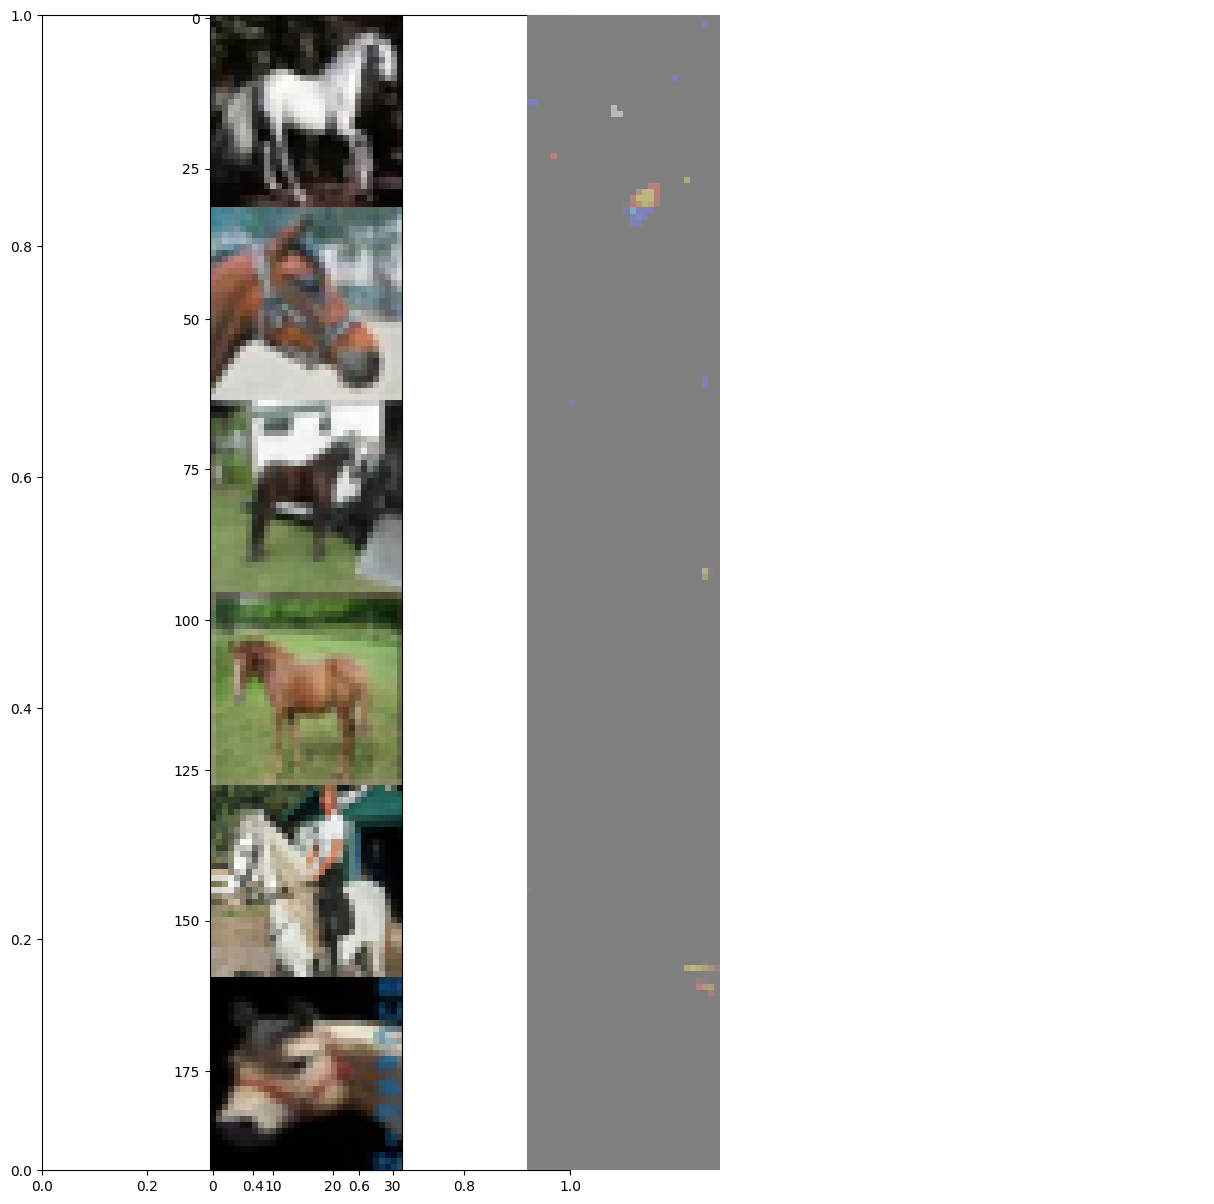

In [56]:
dataset_full=torchvision.datasets.CIFAR10('./', train=False, download=False,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor()
                                ]))
idx = list(np.array(dataset_full.targets)==7) #| (dataset_full.targets==2) | (dataset_full.targets==5) | (dataset_full.targets==6)
dataset_full.targets = list(compress(dataset_full.targets, idx))
dataset_full.data = list(compress(dataset_full.data , idx))

train_loader = torch.utils.data.DataLoader(
dataset_full, batch_size=6, shuffle=False)
batch = next(iter(train_loader))
#(0.1307,), (0.3081,)
#tf.random.uniform(image.shape) < image / 255.0
def test(train_loader, VDM):
    #batch=torch.empty((10,1,28,28), dtype=torch.int64)
    VDM.eval()
    with torch.no_grad():
        data, target = next(iter(train_loader))
        print(data.shape)
        conditioning =target
        output,samples=VDM.recon(data, 1000, 0.5, conditioning=conditioning)
        print(output.max())
        loss=torch.nn.MSELoss()
        print(torch.sqrt(loss(output, data)))
    fig, ax = plt.subplots(1,2,figsize=(15,15))
    plt.axis('off')

    global img, img_in
    #fig.set_cmap('hot')
    
    img=torchvision.utils.make_grid(output, 1, 0)
    img_in=torchvision.utils.make_grid(data, 1, 0)
    fig.add_subplot(1, 1, 1)
    print(img_in.shape, img.shape)
    plt.imshow( np.transpose(img.numpy(), (1, 2, 0)),cmap="hot")
    plt.axis('off')
    fig.add_subplot(1, 2, 1)
    plt.imshow( np.transpose(img_in.numpy(), (1, 2, 0)),cmap="hot" ) 
    
    plt.show()
test(train_loader,VDM)
#loss_recon, loss_latent, loss_diff
#loss_recon should be highest

In [ ]:
class BasicBlock(nn.Module):
        def __init__(self, in_channels, out_channels, downsample):
            super(BasicBlock, self).__init__()
            
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU(inplace=True)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.downsample = downsample
            self.shortcut=nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        def forward(self, x):
            identity = x

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.bn2(out)

            if self.downsample is not None:
                identity = self.shortcut(x)
            else:
                identity=x
            out += identity
            out = self.relu(out)

            return out    
class ResNet18(nn.Module):
    def __init__(self, num_channels=3):
        super(ResNet18, self).__init__()
        
        # define ResNet-18 architecture with 1 output channel
        self.resnet = nn.Sequential(
            nn.Conv2d(num_channels, 8, kernel_size=(3,3), stride=1, padding=0), #stride was lowered to allow deeper network
            # nn.MaxPool2d(kernel_size=3, stride=1, padding=0),
            # nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Sequential(
                 BasicBlock(8, 8, downsample=False),
                 BasicBlock(8, 16, downsample=False)
            ),
            # nn.Sequential(
                # BasicBlock(8, 16, downsample=True),
                # BasicBlock(16, 16, downsample=False)
            # ),
            # nn.Sequential(
            #     BasicBlock(128, 256, downsample=True),
            #     BasicBlock(256, 256,downsample=False)
            # ),
            # nn.Sequential(
            #     BasicBlock(256, 512,downsample=True),
            #     BasicBlock(512, 512,downsample=False)
            # ),
             nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid()
        )
    

    def forward(self, x):
        return self.resnet(x)
class Encoder(nn.Module):

    def __init__(self, z_dim=256, hidden_size=1024, n_layers=3):
        super().__init__()

        self.resnet = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=(3,3), stride=1, padding=0), #stride was lowered to allow deeper network
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=2, bias=False),# change padding here to achieve different size of output
            # nn.Sequential(
            #      BasicBlock(8, 8, downsample=False),
            #      BasicBlock(8, 8, downsample=False)
            # ),
             nn.Conv2d(8, 3, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.resnet(x)

    
class Decoder(nn.Module):

    def __init__(self, z_dim=256, hidden_size=1024, n_layers=3):
        super().__init__()

        self.resnet = nn.Sequential(
        nn.ConvTranspose2d(3, 16, kernel_size=4, stride=2, padding=2),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=0, bias=False),
        # nn.Sequential(
        #       BasicBlock(16, 16, downsample=False),
        #       BasicBlock(16, 32, downsample=False)
        #  ),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(16, 32, kernel_size=4, stride=1, padding=0),
        nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=0),
        nn.Sigmoid()
        )
    def forward(self, x):
        logits=self.resnet(x)
        return torch.distributions.independent.Independent(torch.distributions.Bernoulli(logits=logits), 3)
encoder = Encoder()
x    = torch.rand([128, 3, 32, 32])
print(encoder(x).shape)
decoder =Decoder()
x    = torch.rand([128, 3, 14, 14])
print(decoder(x))
summary(decoder, input_size=(3, 6, 6))

torch.Size([128, 3, 14, 14])
Independent(Bernoulli(logits: torch.Size([128, 3, 32, 32])), 3)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 16, 10, 10]             784
            Conv2d-2             [-1, 16, 4, 4]           2,304
              ReLU-3             [-1, 16, 4, 4]               0
   ConvTranspose2d-4             [-1, 32, 7, 7]           8,224
   ConvTranspose2d-5            [-1, 3, 16, 16]           1,539
           Sigmoid-6            [-1, 3, 16, 16]               0
Total params: 12,851
Trainable params: 12,851
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.05
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x, cond=None):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        if cond!=None:
            print("cond not None, x.shape=",x.shape,"cond.shape=", cond.shape)
            x=x+cond[:,:,None,None]
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        return x


class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, bridge, cond=None):
        x = self.upconv(x)
        # print(x.shape,bridge.shape)
        x = torch.cat([x, bridge], axis=1)
        x = self.conv_block(x, cond)
        return x


class ResUNet(nn.Module):
    def __init__(self, input_channels, output_channels, start_neurons):
        super(ResUNet, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.start_neurons = start_neurons

        self.conv0 = nn.Conv2d(input_channels, start_neurons, kernel_size=3, padding=2)# IF I WANT TO CHANGE INPUT DIMENSIONS - works only when even, I just change padding here
        self.bn0 = nn.BatchNorm2d(start_neurons)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop0 = nn.Dropout2d(p=0.25)

        self.conv1 = ConvBlock(start_neurons, start_neurons * 2)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop1 = nn.Dropout2d(p=0.5)

        self.conv2 = ConvBlock(start_neurons * 2, start_neurons *2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.drop2 = nn.Dropout2d(p=0.5)
        
        self.middle_conv = ConvBlock(start_neurons *2, start_neurons * 4)

        # self.upconv2 = UpConvBlock(start_neurons * 4, start_neurons * 4)
        self.upconv1 = UpConvBlock(start_neurons * 4, start_neurons * 2)
        self.upconv0 = UpConvBlock(start_neurons * 2, start_neurons)

        self.final_conv = nn.Conv2d(start_neurons, output_channels, kernel_size=3)

    def forward(self, x, cond=None):
        # Encoder
        
        x = self.conv0(x)
        x=self.bn0(x)#
        skip0 = x
        x = self.pool0(x)
        x = self.conv1(x)
        skip1 = x #
        x = self.pool1(x)
        x = self.drop1(x)
        # Middle
        x = self.middle_conv(x, cond)
        # Decoder
        print(x.shape,skip1.shape)
        x = self.upconv1(x, skip1)
        x = self.upconv0(x, skip0)
        x = self.final_conv(x)
        return x
unet = ResUNet(3,3, 280)
x  = torch.rand([11, 3, 14, 14])
cond=torch.rand([11, 1120])
print(unet(x,cond).shape)


# summary(unet, input_size=[(3, 14, 14),(1120,1)])

cond not None, x.shape= torch.Size([11, 1120, 4, 4]) cond.shape= torch.Size([11, 1120])
torch.Size([11, 1120, 4, 4]) torch.Size([11, 560, 8, 8])
torch.Size([11, 3, 14, 14])


In [33]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

    
    
def zero_init(module: nn.Module) -> nn.Module:
    """Sets to zero all the parameters of a module, and returns the module."""
    for p in module.parameters():
        nn.init.zeros_(p.data)
    return module
class ResnetBlock(nn.Module):
    def __init__(
        self,
        ch_in,
        ch_out=None,
        condition_dim=None,
        dropout_prob=0.0,
        norm_groups=1,
    ):
        super().__init__()
        ch_out = ch_in if ch_out is None else ch_out
        self.ch_out = ch_out
        self.condition_dim = condition_dim
        self.net1 = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=ch_in),
            nn.SiLU(),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1),
        )
        if condition_dim is not None:
            self.cond_proj = zero_init(nn.Linear(condition_dim, ch_out, bias=False))
        self.net2 = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=ch_out),
            nn.SiLU(),
            *([nn.Dropout(dropout_prob)] * (dropout_prob > 0.0)),
            zero_init(nn.Conv2d(ch_out, ch_out, kernel_size=3, padding=1)),
        )
        if ch_in != ch_out:
            self.skip_conv = nn.Conv2d(ch_in, ch_out, kernel_size=1)

    def forward(self, x, condition):
        h = self.net1(x)
        if condition is not None:
            assert condition.shape == (x.shape[0], self.condition_dim)
            condition = self.cond_proj(condition)
            condition = condition[:, :, None, None]
            h = h + condition
        h = self.net2(h)
        if x.shape[1] != self.ch_out:
            x = self.skip_conv(x)
        assert x.shape == h.shape
        return x + h
mid_block1 = ResnetBlock(ch_in=3, ch_out=3, condition_dim=1120)
mid_attn =  Attention(dim=3)
mid_block2 = ResnetBlock(ch_in=3, ch_out=3, condition_dim=1120)
resnet = ResnetBlock(ch_in=3, ch_out=3, condition_dim=1120)
x  = torch.rand([256, 3, 14, 14])
cond=torch.rand([256, 1120])
print(mid_block2 (mid_attn(mid_block1(x, condition=cond)),condition=cond).shape)

torch.Size([256, 3, 14, 14])


In [ ]:
def get_timestep_embedding(timesteps, embedding_dim):
    t = timesteps.squeeze()
    t = t * 1000
    half_dim = embedding_dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim) * -emb)
    emb = t[:, None] * emb[None, :]
    emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # pad
         emb = np.pad(emb, [(0, 0, 0), (0, 1, 0)], mode='constant')
    # combine last 2 dimensions
    emb = emb.reshape(emb.shape[0], -1)

    assert emb.shape == (t.shape[0], embedding_dim)
    return torch.from_numpy(emb).float()
class ScoreNet(nn.Module):
    def __init__(self, embedding_dim, n_blocks=32):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.dense1 = nn.Linear(self.embedding_dim, self.embedding_dim * 2)
        self.dense2 = nn.Linear(self.embedding_dim * 2, self.embedding_dim * 2)
        self.dense3 = nn.Linear(self.embedding_dim * 2, self.embedding_dim)
        self.resnet = ResUNet(3, 3, 280)

    def forward(self, x, t):
        timestep = get_timestep_embedding(t, self.embedding_dim)
        # assert conditioning.shape[0]==timestep.shape[0] #as the output of encoder is (1, encoded_dim) this condition must eb satisfied
        cond = timestep
        # print(cond.shape, conditioning[:, None].shape)
        # cond = torch.cat((cond, conditioning[:,None]), dim=1)
        cond = nn.SiLU()(self.dense1(cond))
        cond = nn.SiLU()(self.dense2(cond))
        cond = self.dense3(cond)
        print(x.shape, cond.shape)
        # h = torch.reshape(h, (1, 32, 1, 1))  # Reshaped for convolutional layers
        h = self.resnet(x, cond)
        print("output,", h.shape)
        return x + h
unet = ScoreNet(1120)

x  = torch.rand([12, 3, 14,14])
cond=torch.rand([12, 1120])
conditioning = torch.zeros(12, dtype=torch.int64)
timesteps= np.array(12*[0.5], dtype=np.float32)
print(unet(x, timesteps).shape)

torch.Size([12, 3, 14, 14]) torch.Size([12, 1120])
torch.Size([12, 1120, 4, 4]) torch.Size([12, 1120])
torch.Size([12, 1120, 4, 4]) torch.Size([12, 560, 8, 8])
output, torch.Size([12, 3, 14, 14])
torch.Size([12, 3, 14, 14])


In [ ]:
x  = torch.rand([12, 3, 32,32])
timesteps= np.array(12*[0.5], dtype=np.float32)
x=Decoder()(ScoreNet(1120)(Encoder()(x), timesteps))
x

torch.Size([12, 3, 14, 14]) torch.Size([12, 1120])
torch.Size([12, 1120, 4, 4]) torch.Size([12, 1120])
torch.Size([12, 1120, 4, 4]) torch.Size([12, 560, 8, 8])
output, torch.Size([12, 3, 14, 14])


Independent(Bernoulli(logits: torch.Size([12, 3, 32, 32])), 3)

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
import random

from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# KMeans++ Initialization
def kmeans_plus_plus(data, k):
    centroids = [data[0]]
    for _ in range(1, k):
        dist_sq = np.array([min([np.inner(c - x, c - x) for c in centroids]) for x in data])
        probs = dist_sq / dist_sq.sum()
        if dist_sq.sum() == 0:
            print("ajjaajajjaajajjaajajjaajajjaajajjaajajjaajajjaaj")
            # probs = np.ones(len(probs)) / len(probs)
            return 0
        cumulative_probs = probs.cumsum()
        r = np.random.rand()

        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break

        centroids.append(data[i])
        # print(centroids)
    return np.array(centroids)
import numpy as np

def bradley(data, k):
    n_samples, n_features = data.shape
    centroids = np.empty((k, n_features))
    
    # Select the first centroid randomly
    centroids[0] = data[np.random.choice(n_samples)]
    
    # Calculate the distance to the first centroid for each data point
    dist_sq = np.sum((data - centroids[0]) ** 2, axis=1)
    
    for i in range(1, k):
        # Calculate the probability of each data point being selected as the next centroid
        probs = dist_sq / np.sum(dist_sq)
        
        # Randomly select the next centroid based on the probabilities
        idx = np.random.choice(n_samples, p=probs)
        centroids[i] = data[idx]
        
        # Update the distance to the newly selected centroid
        dist_sq = np.minimum(dist_sq, np.sum((data - centroids[i]) ** 2, axis=1))
    
    return centroids

def random_partition(data, k):
    n_samples = len(data)
    
    # Ensure each cluster has at least one point assigned to it
    labels = np.zeros(n_samples, dtype=int)
    labels[:k] = range(k)
    labels[k:] = np.random.choice(k, size=n_samples-k)
    np.random.shuffle(labels)
    
    centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    
    return centroids

def forgy(data, k):
    n_samples = len(data)
    
    # Randomly assign each data point to a cluster
    labels = np.random.choice(k, size=n_samples)
    
    # Compute the initial centroids as the mean of the data points in each cluster
    centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    
    return centroids


def computeLabels(data, centroids):
    labels = np.zeros(len(data), dtype=int)
    for i in range(len(data)):
        minDistance = np.inf
        for j in range(len(centroids)):
            currentDistance = np.linalg.norm(data[i] - centroids[j])
            if currentDistance < minDistance:
                minDistance = currentDistance
                labels[i] = j
    return labels

def computeCentroids(data, labels, k):
    centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        points_in_cluster = data[labels == i]
        if len(points_in_cluster) > 0:
            centroids[i] = points_in_cluster.mean(axis=0)
    return centroids

def kmeans(data, k, initialization):
    if initialization == 'kmeans++':
        centroids = kmeans_plus_plus(data, k)
    elif initialization == 'bradley':
        centroids = bradley(data, k)
    elif initialization == 'forgy':
        centroids = forgy(data, k)       
    else:
        raise ValueError("Invalid initialization method")

    prev_centroids = centroids.copy()
    converged = False
    iterations = 0
    while not converged:
        iterations += 1
        labels = computeLabels(data, centroids)
        new_centroids = computeCentroids(data, labels, k)
        converged = np.linalg.norm(new_centroids - prev_centroids) < 0.00001
        prev_centroids = new_centroids.copy()

    return labels, new_centroids, iterations
# Define the number of clusters, runs, and dataset size
runs = 100 
n_samples = 1000
n_features = [2,7,20,30]

# Define the ranges for k and std
k_values =[3, 5, 8]
std_values = [0.1, 0.3, 0.4, 0.6]

# Generate a list of 10 random seeds
seed_range = range(1, 10000)
random_seeds = random.sample(seed_range, 10)

# Placeholder for all results
all_results_df = pd.DataFrame()
######################################################
# Perform experiments for each k, std, features and seed combinations

for k in k_values:
    for std in std_values:
            for features in n_features:
                    for state in random_seeds:
                        # Create synthetic dataset using make_blobs with specified k and std
                        data, _ = make_blobs(n_samples=n_samples, n_features=features, centers=k, cluster_std=std, center_box=[-3,3], random_state=state)

                        # Standardize the dataset
                        scaler = StandardScaler()
                        data = scaler.fit_transform(data)
                        
                        # def pca_initialization(data, k):
                        #     pca = PCA(n_components=k)
                        #     transformed_data = pca.fit_transform(data)
                        # #     centroids = transformed_data[:k, :]
                        #     return transformed_data
                        #
                        # data=pca_initialization(data,2)

                        init_methods = ['kmeans++', 'bradley', 'forgy']
                        labels = {method: np.zeros((runs, data.shape[0]), dtype=np.int32) for method in init_methods}
                        centroids = {method: [] for method in init_methods}
                        iterations = {method: [] for method in init_methods}
                        costs_runs = {method: [] for method in init_methods} 
                        avg_rand_index = {method: [] for method in init_methods} 

                        # Perform KMeans clustering with each initialization method
                        for method in init_methods:
                            for i in range(runs):
                                
                                labels[method][i], centroids_iter, iter_count = kmeans(data, k, method)
                                centroids[method].append(centroids_iter)
                                iterations[method].append(iter_count)
                                # print(i,centroids[method][i])
                                # print(centroids, labels)
                                cost = np.sum([
                                    np.sum((data[labels[method][i] == j] - centroids[method][i][j]) ** 2)
                                    for j in range(k)
                                ])
                                # print(method,cost )
                            avg_rand_index[method] = np.mean([adjusted_rand_score(labels[method][i], labels[method][(i+1)%runs]) for i in range(runs)])
                            costs_runs[method].append(cost)
                                        # Save the first clustering plot for each combination of parameters
                            plt.figure()
                            plt.scatter(data[:, 0], data[:, 1], c=labels[method][0])
                            plt.scatter(centroids[method][0][:, 0], centroids[method][0][:, 1], marker='X', c='red')
                            plt.title(f"Clustering Result for {method.capitalize()} - k={k}, std={std}, dim={features}")
                            plt.savefig(f"clustering_result_{method}_{k}_{std}_{features}.png")
                            plt.close()
                            
                            
                            
                        # Calculate average Adjusted Rand Index and average iterations for each initialization method
                        results_df = pd.DataFrame({'Initialization Method': [],
                                                'Adjusted Rand Index': [],
                                                'Average Cost': [],
                                                'k': [],
                                                'std': [],
                                                "dim":[],
                                                'seed':[]} )

                        # Append the results of each initialization method to the results DataFrame
                        for method in init_methods:
                            method_results = pd.DataFrame({'Initialization Method': [method.capitalize()],
                                                        'Adjusted Rand Index': [avg_rand_index[method]],
                                                        'k': [k],
                                                        'Average Cost': [np.mean(costs_runs[method])],
                                                        'std': [std],
                                                        "dim":[features],
                                                        'seed':[state]} )
                            results_df = results_df.append(method_results, ignore_index=True)

                        # Append the results for the current k and std to the overall results DataFrame
                        all_results_df = all_results_df.append(results_df, ignore_index=True)
                        
# Save the results to a file
all_results_df.to_csv('clustering_resultstt.csv', index=False)
df=pd.read_csv('clustering_resultstt.csv')
#plot the results
#make df scrollable and vievable in the notebook    
df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
# #make the table interactive for the user
# df.style.set_properties(**{'text-align': 'center'}).set_table_styles([ dict(selector='th', props=[('text-align', 'center')] ) ])


KeyboardInterrupt: 

# Testing Whole model - start by inputing fimensions from output of the encoder



# Animation

tensor([9])
10
Sampling: 0.9
11
Sampling: 0.89
12
Sampling: 0.88
13
Sampling: 0.87
14
Sampling: 0.86
15
Sampling: 0.85
16
Sampling: 0.84
17
Sampling: 0.83
18
Sampling: 0.82
19
Sampling: 0.81
20
Sampling: 0.8
21
Sampling: 0.79
22
Sampling: 0.78
23
Sampling: 0.77
24
Sampling: 0.76
25
Sampling: 0.75
26
Sampling: 0.74
27
Sampling: 0.73
28
Sampling: 0.72
29
Sampling: 0.71
30
Sampling: 0.7
31
Sampling: 0.69
32
Sampling: 0.68
33
Sampling: 0.67
34
Sampling: 0.66
35
Sampling: 0.65
36
Sampling: 0.64
37
Sampling: 0.63
38
Sampling: 0.62
39
Sampling: 0.61
40
Sampling: 0.6
41
Sampling: 0.59
42
Sampling: 0.58
43
Sampling: 0.57
44
Sampling: 0.56
45
Sampling: 0.55
46
Sampling: 0.54
47
Sampling: 0.53
48
Sampling: 0.52
49
Sampling: 0.51
50
Sampling: 0.5
51
Sampling: 0.49
52
Sampling: 0.48
53
Sampling: 0.47
54
Sampling: 0.46
55
Sampling: 0.45
56
Sampling: 0.44
57
Sampling: 0.43
58
Sampling: 0.42
59
Sampling: 0.41
60
Sampling: 0.4
61
Sampling: 0.39
62
Sampling: 0.38
63
Sampling: 0.37
64
Sampling: 0.36
65
S

MovieWriter ffmpeg unavailable; using Pillow instead.


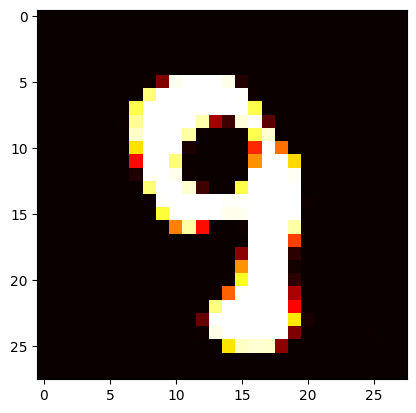

In [ ]:
import matplotlib.animation as animation
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('./', train=False, download=False,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=1, shuffle=True)
#(0.1307,), (0.3081,)
#tf.random.uniform(image.shape) < image / 255.0
samples=[]
    #batch=torch.empty((10,1,28,28), dtype=torch.int64)
VDM.eval()
with torch.no_grad():
    data, target = next(iter(test_loader))
    print(target)
    conditioning =target
    output,samples=VDM.recon(data, 1000, 0.9, conditioning, 1)
#print(len(samples))
timesteps=1000
fig = plt.figure()
ims = []
for i in range(len(samples)):
    im = plt.imshow(samples[i].reshape(28, 28, 1).detach().numpy(), cmap="hot", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=10, blit=True,repeat=True, repeat_delay=1000)
animate.save('diffusion.gif')
#plt.show()

In [ ]:
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('../', train=False, download=False,transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=1, shuffle=True)
data, target = next(iter(test_loader))
img=data
output=VDM.recon(img=img,t=0.9)
plt.imshow( np.transpose(output[0].detach().numpy(), (1, 2, 0)))
output[0].detach().numpy().shape
plt.imshow( np.transpose(img[0].detach().numpy(), (1, 2, 0)))
(torch.prod(torch.tensor(img.shape[1:]))*np.log(2))

RuntimeError: Dataset not found. You can use download=True to download it

In [ ]:
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('../', train=False, download=False,transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=10, shuffle=True)
data, target = next(iter(test_loader))
data.min()

tensor(0.)

In [ ]:
        ################################################################################
        # TODO: implement random choice and save it to self.last_action.               #
        # hint: see np.random.choice function                                          #  
        ################################################################################
        ### START CODE HERE ### (~1 line)

        ### END CODE HERE ###